In [1]:
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def cargar_datos(archivo_json):
    """
    Carga los datos del dataset enriquecido desde un archivo JSON
    
    Args:
        archivo_json (str): Ruta al archivo JSON con los datos
        
    Returns:
        tuple: Dos DataFrames, uno con rutas históricas y otro con información de estaciones
    """
    with open(archivo_json, 'r', encoding='utf-8') as f:
        datos = json.load(f)
    
    # Convertir las rutas históricas a DataFrame
    df_rutas = pd.DataFrame(datos['rutas_historicas'])
    
    # Convertir las estaciones a DataFrame
    df_estaciones = pd.DataFrame(datos['estaciones'])
    
    return df_rutas, df_estaciones

# Ejecutar la carga de datos
print("Cargando datos...")
df_rutas, df_estaciones = cargar_datos('dataset_transporte_enriquecido.json')

# Mostrar información de los datasets
print(f"\nDataset de rutas: {df_rutas.shape[0]} registros, {df_rutas.shape[1]} columnas")
print(f"Dataset de estaciones: {df_estaciones.shape[0]} registros, {df_estaciones.shape[1]} columnas")

# Exploración inicial de los datos
print("\nColumnas en dataset de rutas:")
print(df_rutas.columns.tolist())

print("\nColumnas en dataset de estaciones:")
print(df_estaciones.columns.tolist())

# Muestra de los primeros registros
print("\nMuestra de rutas:")
display(df_rutas.head())

print("\nMuestra de estaciones:")
display(df_estaciones.head())

Cargando datos...

Dataset de rutas: 3600 registros, 10 columnas
Dataset de estaciones: 5 registros, 8 columnas

Columnas en dataset de rutas:
['fecha', 'hora', 'origen', 'destino', 'tiempo_esperado', 'tiempo_real', 'costo', 'distancia_km', 'condiciones', 'metricas']

Columnas en dataset de estaciones:
['id', 'nombre', 'lat', 'lon', 'tipo', 'servicios', 'capacidad_maxima', 'nivel_seguridad']

Muestra de rutas:


,fecha,hora,origen,destino,tiempo_esperado,tiempo_real,costo,distancia_km,condiciones,metricas
0,2025-01-01,0,A,B,10,16.28,2.5,5.2,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 13, 'satisfaccion_usu..."
1,2025-01-01,0,B,C,15,23.31,3.0,7.8,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 22, 'satisfaccion_usu..."
2,2025-01-01,0,C,D,20,28.72,2.0,10.5,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 36, 'satisfaccion_usu..."
3,2025-01-01,0,A,E,15,24.73,4.0,8.3,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 24, 'satisfaccion_usu..."
4,2025-01-01,0,E,D,28,45.62,4.0,12.1,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 35, 'satisfaccion_usu..."



Muestra de estaciones:


,id,nombre,lat,lon,tipo,servicios,capacidad_maxima,nivel_seguridad
0,A,Estación Central,40.7128,-74.0060,terminal,"[taquilla, baños, cafetería, información]",1000,alto
1,B,Universidad,40.7589,-73.9851,estación,"[taquilla, baños, información]",500,medio
2,C,Parque Central,40.7831,-73.9654,estación,"[taquilla, información]",300,medio
3,D,Zona Industrial,40.8000,-73.9200,terminal,"[taquilla, baños, cafetería]",800,alto
4,E,Troncal 112,40.7390,-73.9499,estación,[taquilla],200,bajo


In [3]:
def preparar_features(df_rutas, df_estaciones):
    """
    Prepara las características para el modelo, expandiendo datos anidados
    y combinando información de estaciones
    
    Args:
        df_rutas (DataFrame): DataFrame con información de rutas
        df_estaciones (DataFrame): DataFrame con información de estaciones
        
    Returns:
        DataFrame: Dataset preparado con características para el modelo
    """
    # Hacemos una copia para no modificar los originales
    df_rutas = df_rutas.copy()
    
    # Expandir las columnas anidadas
    df_rutas['clima'] = df_rutas['condiciones'].apply(lambda x: x['clima'])
    df_rutas['evento_especial'] = df_rutas['condiciones'].apply(lambda x: x['evento_especial'])
    df_rutas['es_hora_pico'] = df_rutas['condiciones'].apply(lambda x: x['es_hora_pico'])
    df_rutas['es_fin_semana'] = df_rutas['condiciones'].apply(lambda x: x['es_fin_semana'])
    
    df_rutas['ocupacion'] = df_rutas['metricas'].apply(lambda x: x['ocupacion_porcentaje'])
    df_rutas['satisfaccion'] = df_rutas['metricas'].apply(lambda x: x['satisfaccion_usuario'])
    
    # Combinar con información de estaciones (origen)
    dataset = df_rutas.merge(
        df_estaciones[['id', 'tipo', 'capacidad_maxima', 'nivel_seguridad']],
        left_on='origen',
        right_on='id',
        suffixes=('', '_origen')
    )
    
    # Combinar con información de estaciones (destino)
    dataset = dataset.merge(
        df_estaciones[['id', 'tipo', 'capacidad_maxima', 'nivel_seguridad']],
        left_on='destino',
        right_on='id',
        suffixes=('_origen', '_destino')
    )
    
    # Convertir fecha a características temporales
    dataset['fecha'] = pd.to_datetime(dataset['fecha'])
    dataset['mes'] = dataset['fecha'].dt.month
    dataset['dia_semana'] = dataset['fecha'].dt.dayofweek
    dataset['hora'] = dataset['fecha'].dt.hour
    
    return dataset

# Ejecutar la preparación de características
print("Preparando features...")
dataset = preparar_features(df_rutas, df_estaciones)

# Mostrar información del dataset combinado
print(f"\nDataset combinado: {dataset.shape[0]} registros, {dataset.shape[1]} columnas")
print("\nColumnas en el dataset final:")
print(dataset.columns.tolist())

# Mostrar estadísticas descriptivas
print("\nEstadísticas descriptivas de variables numéricas:")
display(dataset.describe())

# Verificar valores nulos
print("\nVerificación de valores nulos:")
display(dataset.isnull().sum())

# Mostrar muestra del dataset final
print("\nMuestra del dataset final:")
display(dataset.head())

Preparando features...

Dataset combinado: 3600 registros, 26 columnas

Columnas en el dataset final:
['fecha', 'hora', 'origen', 'destino', 'tiempo_esperado', 'tiempo_real', 'costo', 'distancia_km', 'condiciones', 'metricas', 'clima', 'evento_especial', 'es_hora_pico', 'es_fin_semana', 'ocupacion', 'satisfaccion', 'id_origen', 'tipo_origen', 'capacidad_maxima_origen', 'nivel_seguridad_origen', 'id_destino', 'tipo_destino', 'capacidad_maxima_destino', 'nivel_seguridad_destino', 'mes', 'dia_semana']

Estadísticas descriptivas de variables numéricas:


,fecha,hora,tiempo_esperado,tiempo_real,costo,distancia_km,ocupacion,satisfaccion,capacidad_maxima_origen,capacidad_maxima_destino,mes,dia_semana
count,3600,3600.0,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.000000,3600.0,3600.000000
mean,2025-01-15 11:59:59.999999744,0.0,17.600000,29.116758,3.100000,8.780000,40.199722,79.915000,600.000000,520.000000,1.0,2.966667
min,2025-01-01 00:00:00,0.0,10.000000,9.000000,2.000000,5.200000,10.000000,60.000000,200.000000,200.000000,1.0,0.000000
25%,2025-01-08 00:00:00,0.0,15.000000,20.000000,2.500000,7.800000,24.000000,76.000000,300.000000,300.000000,1.0,1.000000
50%,2025-01-15 12:00:00,0.0,15.000000,26.390000,3.000000,8.300000,37.000000,81.000000,500.000000,500.000000,1.0,3.000000
75%,2025-01-23 00:00:00,0.0,20.000000,36.337500,4.000000,10.500000,49.000000,85.000000,1000.000000,800.000000,1.0,5.000000
max,2025-01-30 00:00:00,0.0,28.000000,84.030000,4.000000,12.100000,100.000000,90.000000,1000.000000,800.000000,1.0,6.000000
std,NaN,0.0,6.086895,12.742498,0.800111,2.366253,21.863805,7.163901,340.635041,248.227951,0.0,1.940774



Verificación de valores nulos:


fecha                       0
hora                        0
origen                      0
destino                     0
tiempo_esperado             0
tiempo_real                 0
costo                       0
distancia_km                0
condiciones                 0
metricas                    0
clima                       0
evento_especial             0
es_hora_pico                0
es_fin_semana               0
ocupacion                   0
satisfaccion                0
id_origen                   0
tipo_origen                 0
capacidad_maxima_origen     0
nivel_seguridad_origen      0
id_destino                  0
tipo_destino                0
capacidad_maxima_destino    0
nivel_seguridad_destino     0
mes                         0
dia_semana                  0
dtype: int64


Muestra del dataset final:


,fecha,hora,origen,destino,tiempo_esperado,tiempo_real,costo,distancia_km,condiciones,metricas,...,id_origen,tipo_origen,capacidad_maxima_origen,nivel_seguridad_origen,id_destino,tipo_destino,capacidad_maxima_destino,nivel_seguridad_destino,mes,dia_semana
0,2025-01-01,0,A,B,10,16.28,2.5,5.2,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 13, 'satisfaccion_usu...",...,A,terminal,1000,alto,B,estación,500,medio,1,2
1,2025-01-01,0,B,C,15,23.31,3.0,7.8,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 22, 'satisfaccion_usu...",...,B,estación,500,medio,C,estación,300,medio,1,2
2,2025-01-01,0,C,D,20,28.72,2.0,10.5,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 36, 'satisfaccion_usu...",...,C,estación,300,medio,D,terminal,800,alto,1,2
3,2025-01-01,0,A,E,15,24.73,4.0,8.3,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 24, 'satisfaccion_usu...",...,A,terminal,1000,alto,E,estación,200,bajo,1,2
4,2025-01-01,0,E,D,28,45.62,4.0,12.1,"{'clima': 'nublado', 'evento_especial': 'parti...","{'ocupacion_porcentaje': 35, 'satisfaccion_usu...",...,E,estación,200,bajo,D,terminal,800,alto,1,2


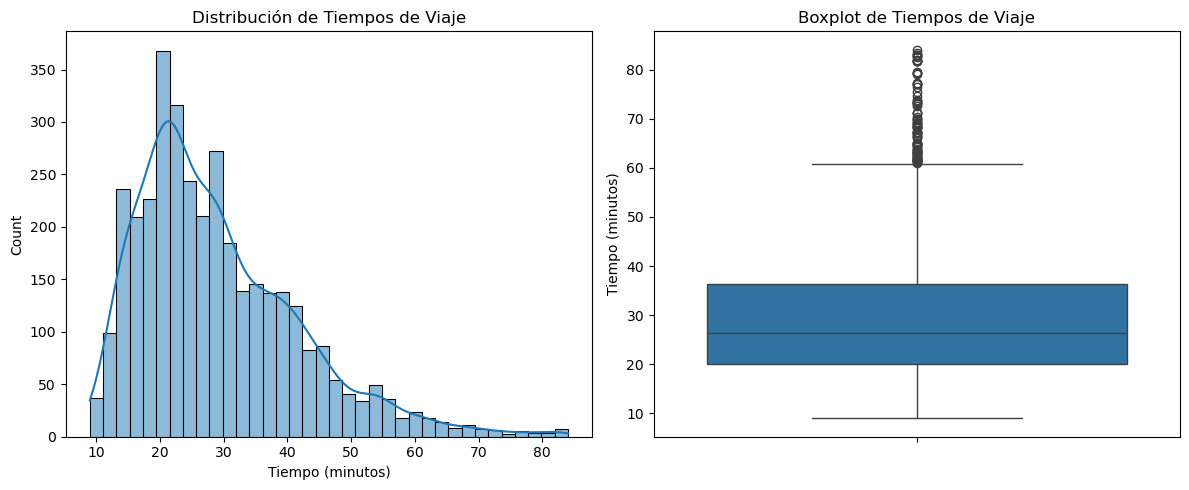

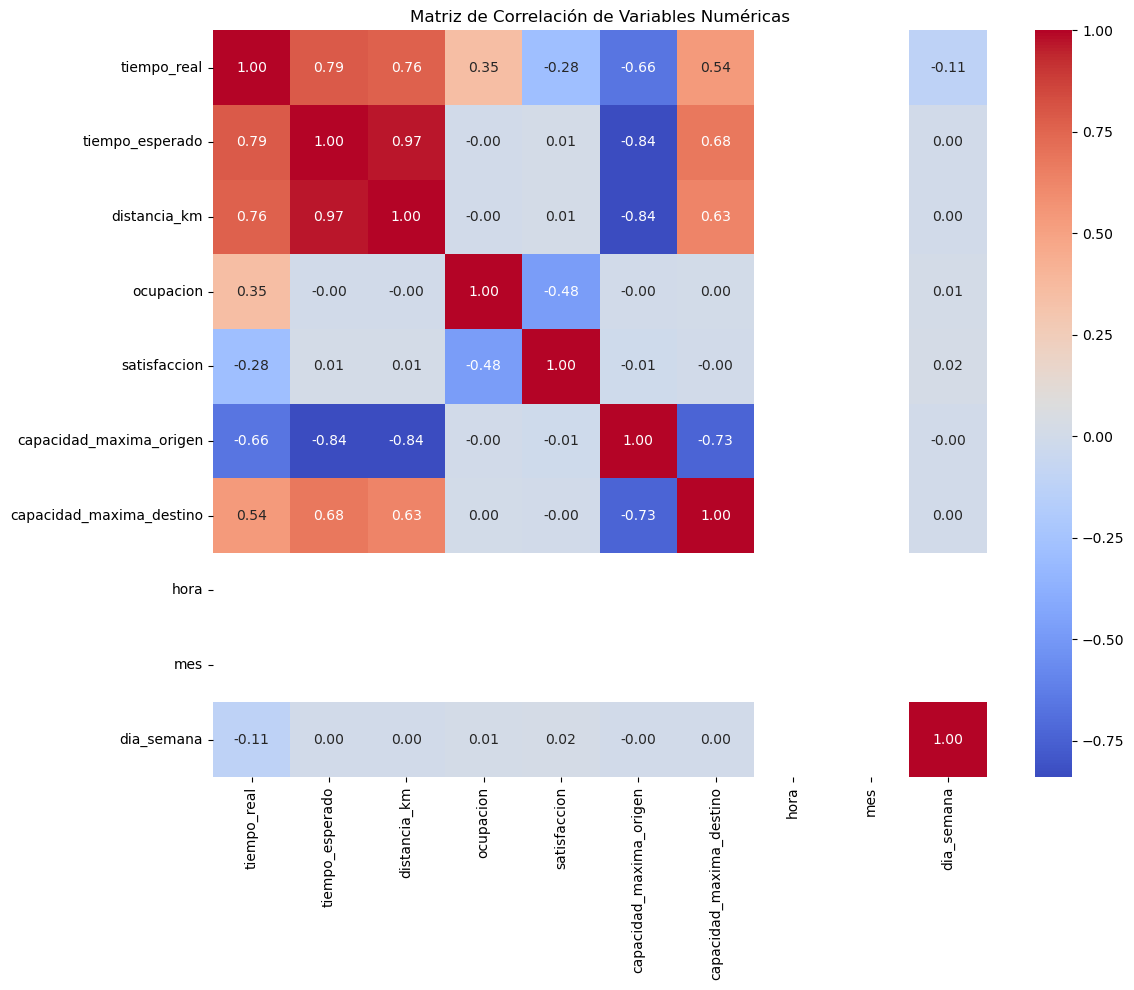

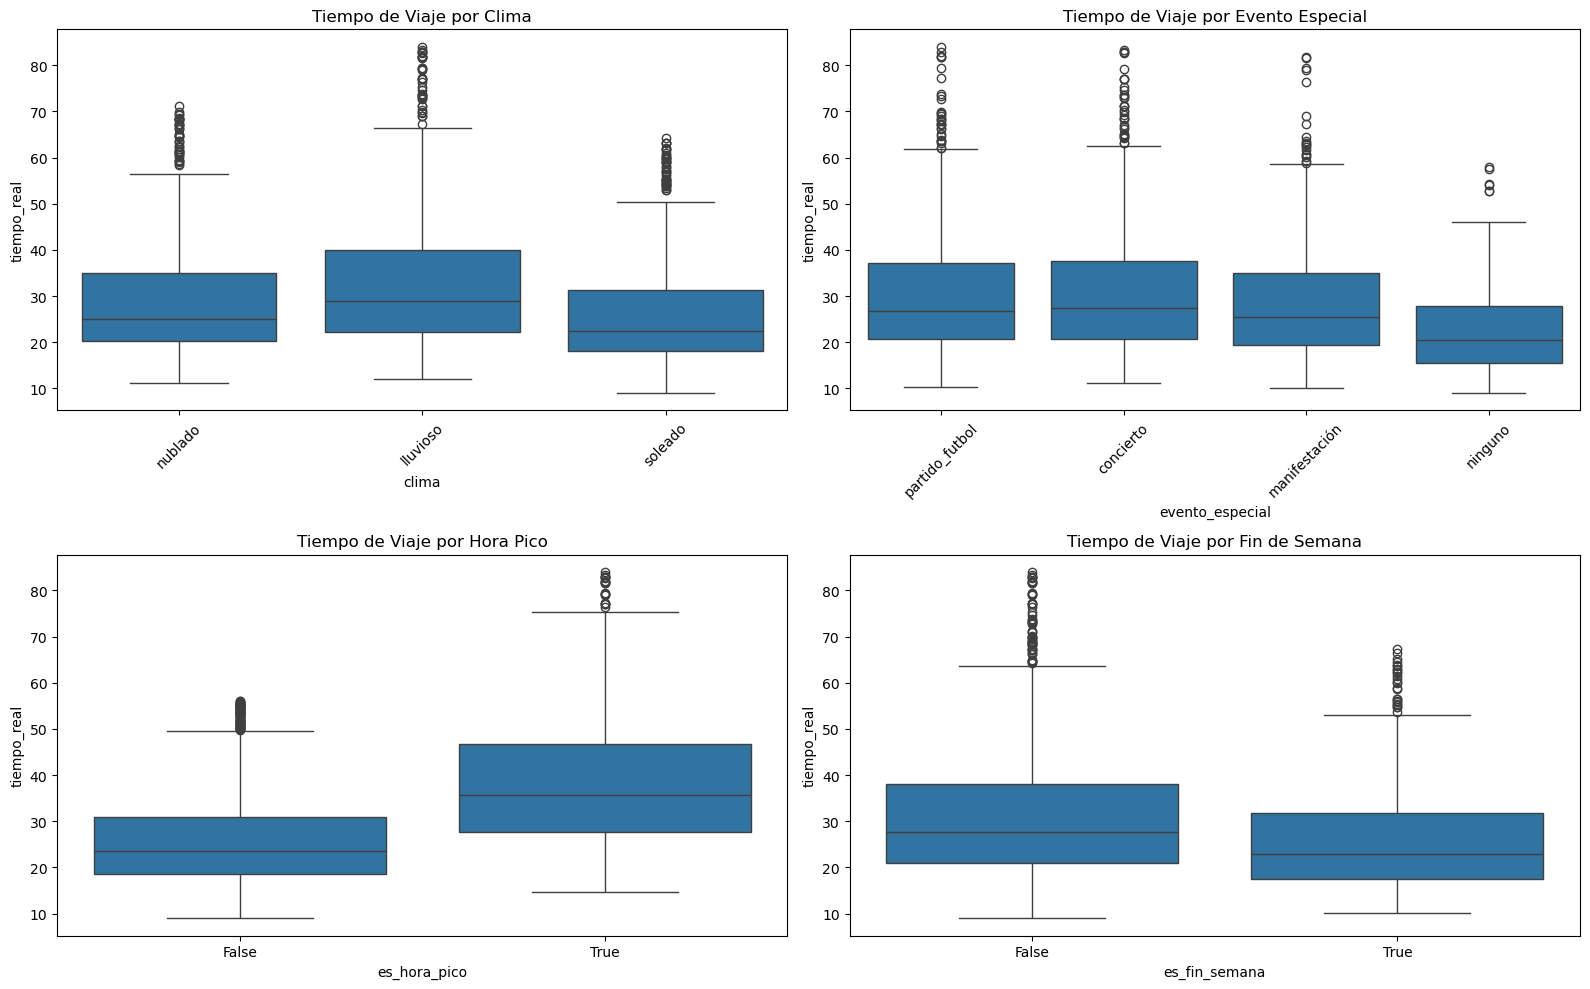

In [4]:
# Análisis visual de la distribución del tiempo real de viaje
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(dataset['tiempo_real'], kde=True)
plt.title('Distribución de Tiempos de Viaje')
plt.xlabel('Tiempo (minutos)')

plt.subplot(1, 2, 2)
sns.boxplot(y=dataset['tiempo_real'])
plt.title('Boxplot de Tiempos de Viaje')
plt.ylabel('Tiempo (minutos)')

plt.tight_layout()
plt.show()

# Análisis de correlación entre variables numéricas
numeric_cols = ['tiempo_real', 'tiempo_esperado', 'distancia_km', 'ocupacion', 
                'satisfaccion', 'capacidad_maxima_origen', 'capacidad_maxima_destino',
                'hora', 'mes', 'dia_semana']

plt.figure(figsize=(12, 10))
correlation = dataset[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.show()

# Análisis de la relación entre variables categóricas y tiempo de viaje
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='clima', y='tiempo_real', data=dataset)
plt.title('Tiempo de Viaje por Clima')
plt.xticks(rotation=45)

plt.subplot(2, 2, 2)
sns.boxplot(x='evento_especial', y='tiempo_real', data=dataset)
plt.title('Tiempo de Viaje por Evento Especial')
plt.xticks(rotation=45)

plt.subplot(2, 2, 3)
sns.boxplot(x='es_hora_pico', y='tiempo_real', data=dataset)
plt.title('Tiempo de Viaje por Hora Pico')

plt.subplot(2, 2, 4)
sns.boxplot(x='es_fin_semana', y='tiempo_real', data=dataset)
plt.title('Tiempo de Viaje por Fin de Semana')

plt.tight_layout()
plt.show()

In [5]:
# Separar features y target
X = dataset.drop(['tiempo_real', 'tiempo_esperado', 'fecha', 'id_origen', 'id_destino', 
                  'origen', 'destino', 'condiciones', 'metricas'], axis=1)
y = dataset['tiempo_real']

# Definir características para el modelo
numeric_features = [
    'distancia_km', 'hora', 'mes', 'dia_semana',
    'ocupacion', 'satisfaccion',
    'capacidad_maxima_origen', 'capacidad_maxima_destino'
]

categorical_features = [
    'clima', 'evento_especial', 'es_hora_pico', 'es_fin_semana',
    'tipo_origen', 'tipo_destino',
    'nivel_seguridad_origen', 'nivel_seguridad_destino'
]

# Verificar las columnas seleccionadas
print("Features numéricas:")
print(numeric_features)
print("\nFeatures categóricas:")
print(categorical_features)

# Split datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"\nConjunto de entrenamiento: {X_train.shape[0]} registros")
print(f"Conjunto de prueba: {X_test.shape[0]} registros")

Features numéricas:
['distancia_km', 'hora', 'mes', 'dia_semana', 'ocupacion', 'satisfaccion', 'capacidad_maxima_origen', 'capacidad_maxima_destino']

Features categóricas:
['clima', 'evento_especial', 'es_hora_pico', 'es_fin_semana', 'tipo_origen', 'tipo_destino', 'nivel_seguridad_origen', 'nivel_seguridad_destino']

Conjunto de entrenamiento: 2880 registros
Conjunto de prueba: 720 registros


In [6]:
def entrenar_modelo(X, y, numeric_features, categorical_features):
    """
    Entrena un modelo de Random Forest con las características seleccionadas
    
    Args:
        X (DataFrame): Features de entrenamiento
        y (Series): Variable objetivo
        numeric_features (list): Lista de nombres de características numéricas
        categorical_features (list): Lista de nombres de características categóricas
        
    Returns:
        Pipeline: Modelo entrenado con preprocesamiento incorporado
    """
    # Crear preprocessador
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ])
    
    # Crear pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(
            n_estimators=100,
            max_depth=15,
            min_samples_split=5,
            random_state=42
        ))
    ])
    
    # Entrenar modelo
    model.fit(X[numeric_features + categorical_features], y)
    
    return model

# Entrenar el modelo
print("Entrenando modelo de Random Forest...")
model = entrenar_modelo(X_train, y_train, numeric_features, categorical_features)
print("¡Modelo entrenado exitosamente!")

Entrenando modelo de Random Forest...
¡Modelo entrenado exitosamente!


Evaluando modelo en conjunto de prueba...

Métricas del modelo:
RMSE: 1.93 minutos
MAE: 1.50 minutos
R² Score: 0.976

Estadísticas de los errores:


count    720.000000
mean      -0.088013
std        1.931449
min       -7.312685
25%       -1.317839
50%       -0.087405
75%        1.123610
max        6.679216
Name: Error, dtype: float64

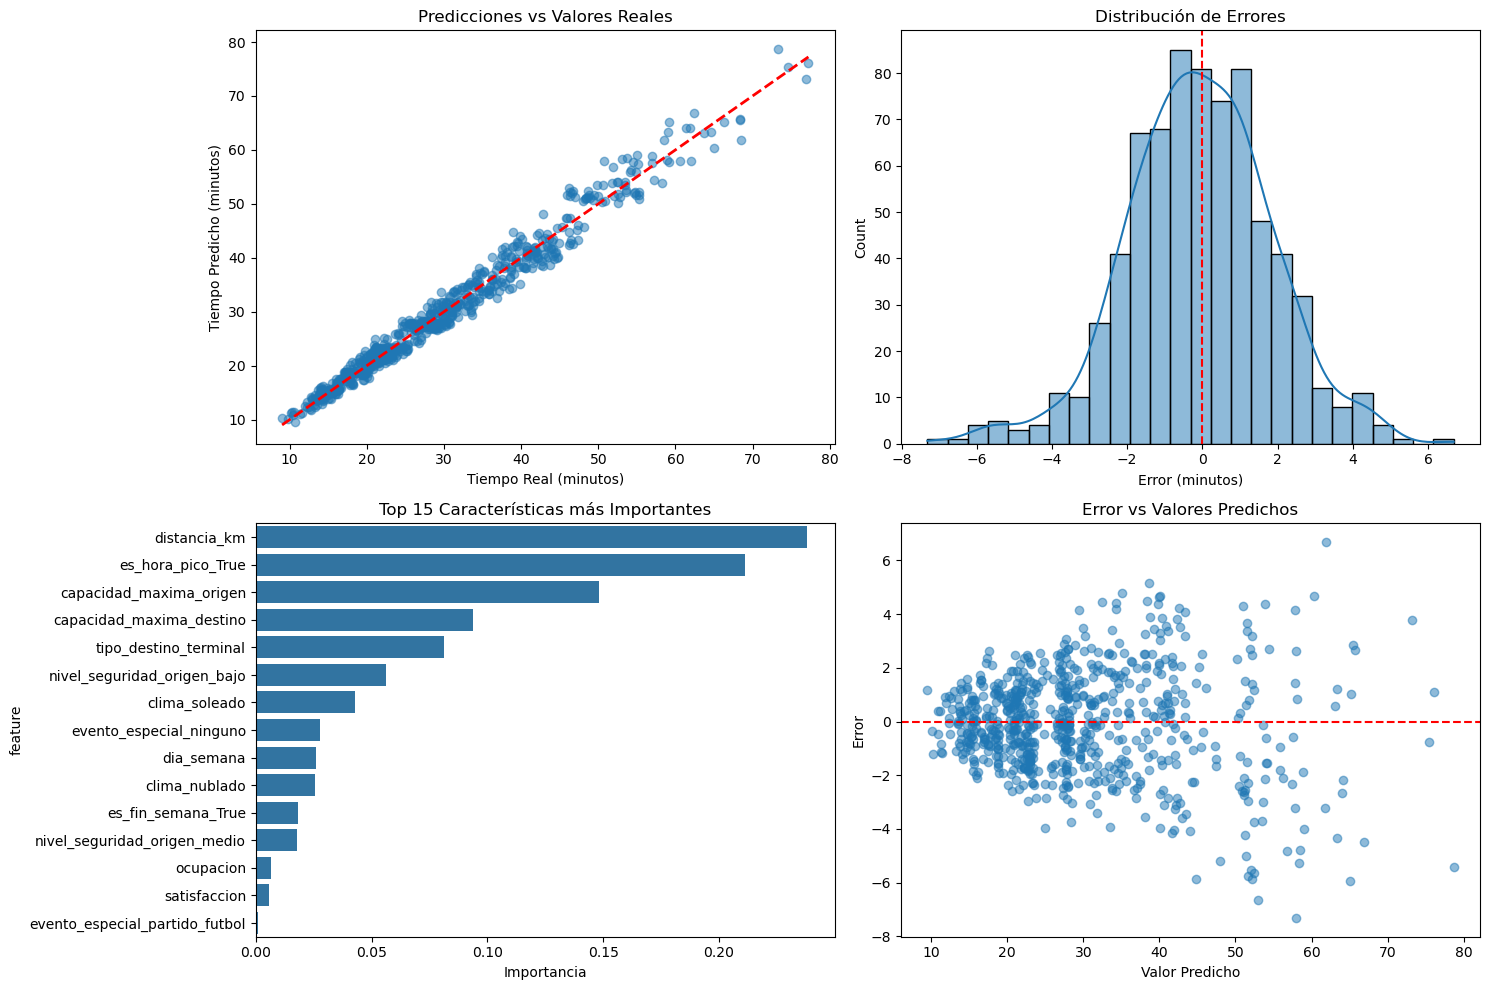


Realizando validación cruzada (5-fold)...
RMSE en validación cruzada: 3.40 ± 1.11


In [7]:
def evaluar_modelo(model, X, y, numeric_features, categorical_features):
    """
    Evalúa el modelo y muestra métricas y visualizaciones
    
    Args:
        model (Pipeline): Modelo entrenado
        X (DataFrame): Features de evaluación
        y (Series): Valores reales
        numeric_features (list): Lista de nombres de características numéricas
        categorical_features (list): Lista de nombres de características categóricas
    """
    # Predicciones
    y_pred = model.predict(X[numeric_features + categorical_features])
    
    # Calcular métricas
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print("\nMétricas del modelo:")
    print(f"RMSE: {rmse:.2f} minutos")
    print(f"MAE: {mae:.2f} minutos")
    print(f"R² Score: {r2:.3f}")
    
    # Crear DataFrame con resultados para análisis
    results_df = pd.DataFrame({
        'Actual': y,
        'Predicción': y_pred,
        'Error': y - y_pred
    })
    
    # Mostrar estadísticas de los errores
    print("\nEstadísticas de los errores:")
    display(results_df['Error'].describe())
    
    # Visualizaciones
    plt.figure(figsize=(15, 10))
    
    # Gráfico 1: Predicciones vs Valores Reales
    plt.subplot(2, 2, 1)
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel('Tiempo Real (minutos)')
    plt.ylabel('Tiempo Predicho (minutos)')
    plt.title('Predicciones vs Valores Reales')
    
    # Gráfico 2: Histograma de errores
    plt.subplot(2, 2, 2)
    sns.histplot(results_df['Error'], kde=True)
    plt.axvline(x=0, color='r', linestyle='--')
    plt.title('Distribución de Errores')
    plt.xlabel('Error (minutos)')
    
    # Gráfico 3: Importancia de características
    if hasattr(model['regressor'], 'feature_importances_'):
        plt.subplot(2, 2, 3)
        # Obtener nombres de todas las características después del preprocesamiento
        feature_names = (
            numeric_features + 
            model['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features).tolist()
        )
        
        # Obtener importancias
        importances = pd.DataFrame({
            'feature': feature_names,
            'importance': model['regressor'].feature_importances_
        })
        importances = importances.sort_values('importance', ascending=False)
        
        # Mostrar top 15 características
        sns.barplot(data=importances.head(15), x='importance', y='feature')
        plt.title('Top 15 Características más Importantes')
        plt.xlabel('Importancia')
    
    # Gráfico 4: Error vs Valores predichos (para detectar patrones)
    plt.subplot(2, 2, 4)
    plt.scatter(y_pred, results_df['Error'], alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Valor Predicho')
    plt.ylabel('Error')
    plt.title('Error vs Valores Predichos')
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Evaluar en conjunto de prueba
print("Evaluando modelo en conjunto de prueba...")
results_df = evaluar_modelo(model, X_test, y_test, numeric_features, categorical_features)

# Validación cruzada para evaluar la robustez del modelo
print("\nRealizando validación cruzada (5-fold)...")
cv_scores = cross_val_score(
    model, 
    X[numeric_features + categorical_features], 
    y, 
    cv=5, 
    scoring='neg_root_mean_squared_error'
)

print(f"RMSE en validación cruzada: {-cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Análisis de rendimiento por subgrupos...

Rendimiento por clima:


,RMSE,MAE,Count
soleado,1.621397,1.285654,216
lluvioso,2.173900,1.674361,266
nublado,1.904089,1.512143,238



Rendimiento por hora pico:


,RMSE,MAE,Count
False,1.736944,1.345672,539
True,2.421879,1.975991,181



Rendimiento por fin de semana:


,RMSE,MAE,Count
True,1.680832,1.394352,189
False,2.014001,1.543199,531


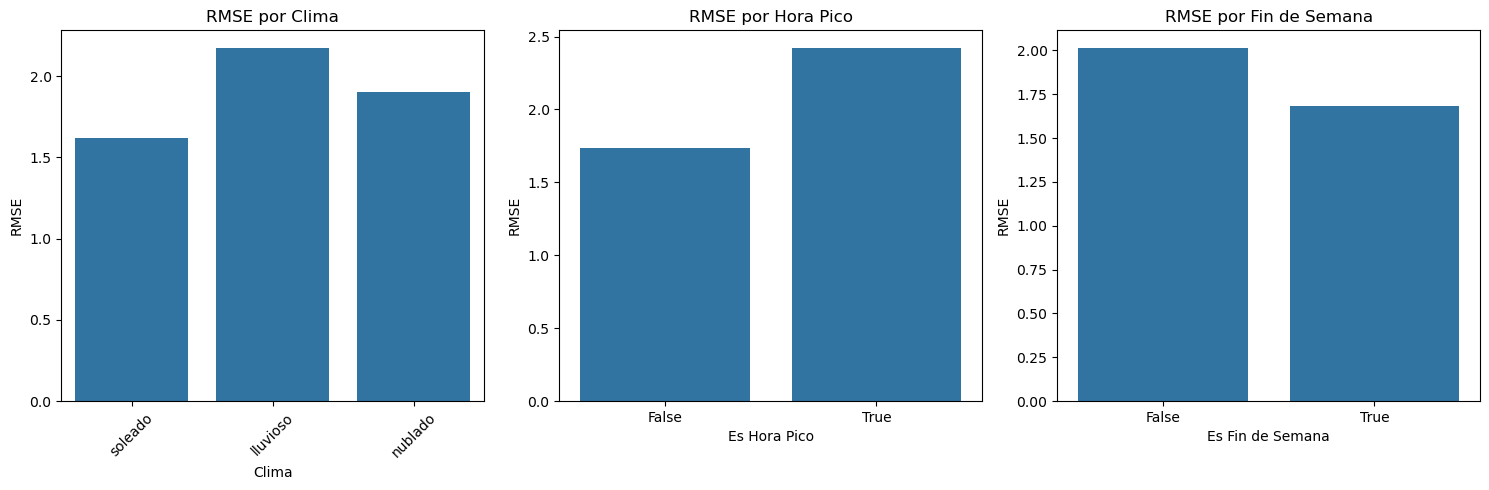

In [16]:
# Analizar el rendimiento del modelo en diferentes subgrupos
print("Análisis de rendimiento por subgrupos...")

# Función para calcular métricas por grupo
def calcular_metricas_grupo(df, grupo):
    resultados = {}
    
    for valor in df[grupo].unique():
        mask = df[grupo] == valor
        if mask.sum() > 0:  # Asegurarse que hay datos en este grupo
            mse_grupo = mean_squared_error(
                results_df.loc[mask, 'Actual'], 
                results_df.loc[mask, 'Predicción']
            )
            rmse_grupo = np.sqrt(mse_grupo)
            mae_grupo = mean_absolute_error(
                results_df.loc[mask, 'Actual'], 
                results_df.loc[mask, 'Predicción']
            )
            
            resultados[valor] = {
                'RMSE': rmse_grupo,
                'MAE': mae_grupo,
                'Count': mask.sum()
            }
    
    return pd.DataFrame.from_dict(resultados, orient='index')

# Combinar resultados con características del dataset de prueba
results_df = results_df.reset_index()
X_test_reset = X_test.reset_index()
analysis_df = pd.concat([results_df, X_test_reset], axis=1)

# Analizar por clima
clima_metrics = calcular_metricas_grupo(analysis_df, 'clima')
print("\nRendimiento por clima:")
display(clima_metrics)

# Analizar por hora pico
hora_pico_metrics = calcular_metricas_grupo(analysis_df, 'es_hora_pico')
print("\nRendimiento por hora pico:")
display(hora_pico_metrics)

# Analizar por fin de semana
fin_semana_metrics = calcular_metricas_grupo(analysis_df, 'es_fin_semana')
print("\nRendimiento por fin de semana:")
display(fin_semana_metrics)

# Visualizar RMSE por grupos
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.barplot(data=clima_metrics.reset_index(), x='index', y='RMSE')
plt.title('RMSE por Clima')
plt.xlabel('Clima')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(data=hora_pico_metrics.reset_index(), x='index', y='RMSE')
plt.title('RMSE por Hora Pico')
plt.xlabel('Es Hora Pico')

plt.subplot(1, 3, 3)
sns.barplot(data=fin_semana_metrics.reset_index(), x='index', y='RMSE')
plt.title('RMSE por Fin de Semana')
plt.xlabel('Es Fin de Semana')

plt.tight_layout()
plt.show()

In [14]:
# Verificar las categorías existentes
print("Valores únicos para 'clima':")
print(dataset['clima'].unique())

print("Valor problemático en los datos de predicción:")
print(nuevo_viaje['clima'].iloc[0])

Valores únicos para 'clima':
['nublado' 'lluvioso' 'soleado']
Valor problemático en los datos de predicción:
lluvioso


Guardando modelo...
Modelo guardado como 'modelo_tiempo_viaje.pkl'

Ejemplo de predicción con caso hipotético:
Tiempo de viaje predicho: 31.43 minutos

Experimentando con diferentes condiciones:

Tiempo predicho por clima:
  soleado: 24.29 minutos
  lluvioso: 31.43 minutos
  nublado: 32.69 minutos

Tiempo predicho por hora del día:
  7:00: 31.43 minutos
  8:00: 31.43 minutos
  12:00: 31.43 minutos
  15:00: 31.43 minutos
  18:00: 31.43 minutos
  21:00: 31.43 minutos

Tiempo predicho por nivel de ocupación:
  30%: 31.31 minutos
  50%: 31.45 minutos
  70%: 31.46 minutos
  90%: 31.43 minutos


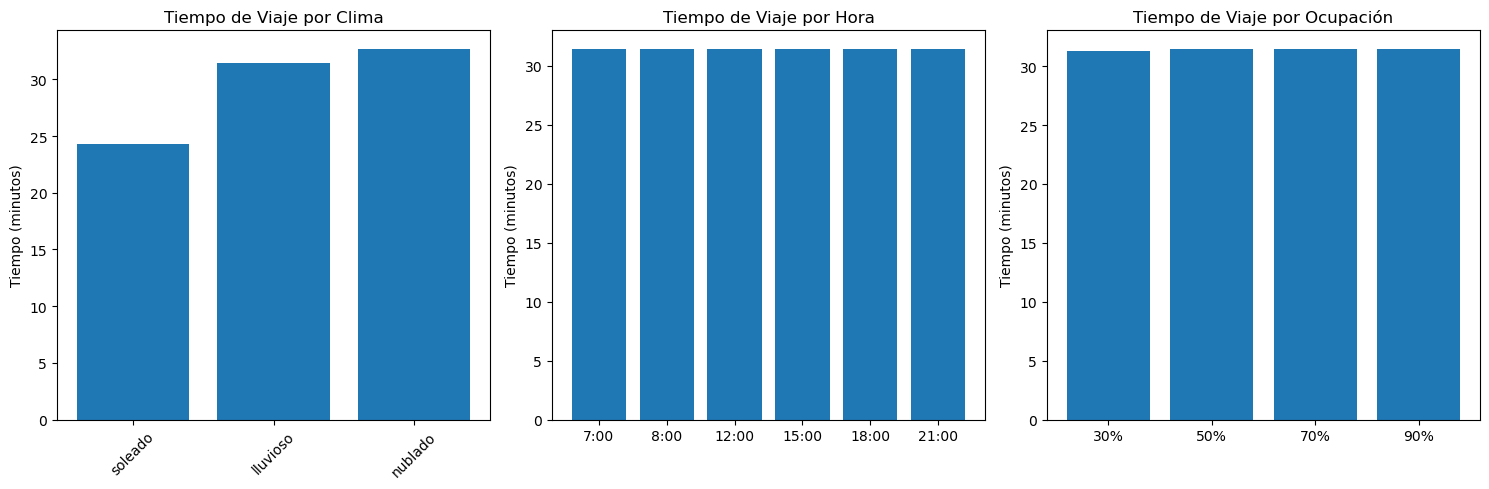

In [15]:
import pickle

# Guardar el modelo
print("Guardando modelo...")
with open('modelo_tiempo_viaje.pkl', 'wb') as modelo_file:
    pickle.dump(model, modelo_file)
print("Modelo guardado como 'modelo_tiempo_viaje.pkl'")

# Función para hacer predicciones con nuevos datos
def predecir_tiempo_viaje(model, datos, numeric_features, categorical_features):
    """
    Realiza predicciones para nuevos datos
    
    Args:
        model: Modelo entrenado
        datos: DataFrame con características necesarias
        numeric_features: Lista de características numéricas
        categorical_features: Lista de características categóricas
        
    Returns:
        float: Tiempo de viaje predicho en minutos
    """
    # Asegurarse que todas las columnas necesarias estén presentes
    for col in numeric_features + categorical_features:
        if col not in datos.columns:
            raise ValueError(f"Columna faltante en los datos: {col}")
    
    # Realizar predicción
    pred = model.predict(datos[numeric_features + categorical_features])
    return pred[0]

# Ejemplo de predicción con un caso hipotético
print("\nEjemplo de predicción con caso hipotético:")

# Crear un nuevo caso de ejemplo
nuevo_viaje = pd.DataFrame({
    'distancia_km': [5.2],
    'hora': [8],  # Hora pico mañana
    'mes': [3],   # Marzo
    'dia_semana': [0],  # Lunes
    'ocupacion': [85],  # Alta ocupación
    'satisfaccion': [3.5],
    'capacidad_maxima_origen': [250],
    'capacidad_maxima_destino': [300],
    'clima': ['lluvioso'],
    'evento_especial': ['ninguno'],
    'es_hora_pico': [True],
    'es_fin_semana': [False],
    'tipo_origen': ['terminal'],
    'tipo_destino': ['terminal'],
    'nivel_seguridad_origen': ['alto'],
    'nivel_seguridad_destino': ['alto']
})

# Realizar predicción
tiempo_predicho = predecir_tiempo_viaje(model, nuevo_viaje, numeric_features, categorical_features)
print(f"Tiempo de viaje predicho: {tiempo_predicho:.2f} minutos")

# Experimentar con diferentes condiciones
print("\nExperimentando con diferentes condiciones:")

# Función para comparar condiciones
def comparar_condiciones(base_data, campo, valores):
    """Compara predicciones cambiando un campo específico"""
    resultados = {}
    
    for valor in valores:
        # Crear copia de los datos base
        data_copy = base_data.copy()
        # Modificar el campo
        data_copy[campo] = [valor]
        # Predecir
        pred = predecir_tiempo_viaje(model, data_copy, numeric_features, categorical_features)
        resultados[valor] = pred
    
    return resultados

# Comparar diferentes climas
climas = ['soleado', 'lluvioso', 'nublado']
resultados_clima = comparar_condiciones(nuevo_viaje, 'clima', climas)

# Comparar diferentes horas
horas = [7, 8, 12, 15, 18, 21]
resultados_horas = comparar_condiciones(nuevo_viaje, 'hora', horas)

# Comparar diferentes ocupaciones
ocupaciones = [30, 50, 70, 90]
resultados_ocupacion = comparar_condiciones(nuevo_viaje, 'ocupacion', ocupaciones)

# Mostrar resultados
print("\nTiempo predicho por clima:")
for clima, tiempo in resultados_clima.items():
    print(f"  {clima}: {tiempo:.2f} minutos")

print("\nTiempo predicho por hora del día:")
for hora, tiempo in resultados_horas.items():
    print(f"  {hora}:00: {tiempo:.2f} minutos")

print("\nTiempo predicho por nivel de ocupación:")
for ocupacion, tiempo in resultados_ocupacion.items():
    print(f"  {ocupacion}%: {tiempo:.2f} minutos")

# Visualizar resultados
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.bar(resultados_clima.keys(), resultados_clima.values())
plt.title('Tiempo de Viaje por Clima')
plt.ylabel('Tiempo (minutos)')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
plt.bar([f"{h}:00" for h in resultados_horas.keys()], resultados_horas.values())
plt.title('Tiempo de Viaje por Hora')
plt.ylabel('Tiempo (minutos)')

plt.subplot(1, 3, 3)
plt.bar([f"{o}%" for o in resultados_ocupacion.keys()], resultados_ocupacion.values())
plt.title('Tiempo de Viaje por Ocupación')
plt.ylabel('Tiempo (minutos)')

plt.tight_layout()
plt.show()